<a href="https://colab.research.google.com/github/cruzdany/UNIT-1-NLP/blob/main/NLP_Extemporaneous_Unit_1_Daniel_Maga%C3%B1a_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import re
from numpy import *  
import matplotlib.pyplot as plt
import numpy as np
import operator
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
import pickle
nice_model = open('nice_model.pickle','rb') 
df = pickle.load(nice_model)

In [3]:
df.sample(5)

,body,clean_text,postag_text,topics_clean
653,"Shr 47 cts vs 40 cts\n Net 4,258,000 vs 5,9...",shr ct vs ct net vs rev mln vs mln avg shr vs ...,"[(shr, NN), (ct, NN), (vs, JJ), (ct, JJ), (net...",2
6701,The Federal Reserve is buying one\nbillion dlr...,feder reserv buy one billion dlr treasuri bill...,"[(feder, NN), (reserv, NN), (buy, VBP), (one, ...",4
1727,Tonka Corp said it expects\nresults for its fi...,tonka corp said expect result fiscal first qua...,"[(tonka, NN), (corp, NN), (said, VBD), (expect...",2
498,"Shell Francaise <SFMF.PA>, a subsidiary of\n<S...",shell francais sfmfpa subsidiari shell petrole...,"[(shell, NN), (francais, NNS), (sfmfpa, VBP), ...",2
3411,Qtr ends Sept 30\n Shr profit seven cts vs ...,qtr end sept shr profit seven ct vs loss two c...,"[(qtr, JJ), (end, NN), (sept, NN), (shr, JJ), ...",2


Import Pickle

In [4]:
df.columns

Index(['body', 'clean_text', 'postag_text', 'topics_clean'], dtype='object')

In [39]:
df.isnull().sum()

body            0
clean_text      0
postag_text     0
topics_clean    0
dtype: int64

In [40]:
b = pd.get_dummies(df["topics_clean"],prefix='topic',drop_first=True)
b

,topic_1,topic_2,topic_3,topic_4,topic_5
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
7013,0,0,1,0,0
7014,0,0,1,0,0
7015,0,0,1,0,0
7016,0,0,1,0,0


In [77]:
y = b[["topic_1", "topic_2", "topic_3", "topic_4", "topic_5"]]

In [79]:
x = df[["clean_text"]]

In [80]:
x.shape

(7018, 1)

In [78]:
y.shape

(7018, 5)

In [44]:
x

,clean_text
0,champion product inc said board director appro...
1,shr ct vs dlr net vs asset mln vs mln deposit ...
2,oper shr loss two ct vs profit seven ct oper s...
3,shr one dlr vs ct net mln vs mln rev mln vs ml...
4,dean food co expect earn fourth quarter end ma...
...,...
7013,uk chancellor exchequ nigel lawson said collap...
7014,presid reagan said pleas action bank reduc pri...
7015,feder reserv enter govern secur market arrang ...
7016,feder deposit insur corp chairman william seid...


In [45]:
x.shape

(7018, 1)

In [46]:
y.value_counts()

topic_1  topic_2  topic_3  topic_4  topic_5
0        1        0        0        0          3735
         0        0        0        0          2125
1        0        0        0        0           355
0        0        0        0        1           333
                           1        0           259
                  1        0        0           211
dtype: int64

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.clean_text, y, test_size=0.2,
                                                    random_state=np.random)
print(X_train.shape, X_test.shape, len(y_train), len(y_test))

(5614,) (1404,) 5614 1404


In [48]:
"""y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))"""

"y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))\ny_test = np.asarray(test_labels).astype('float32').reshape((-1,1))"

In [49]:
from keras.preprocessing.text import Tokenizer
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)
maxlen=400
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)
V_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
V_test = pad_sequences(list_tokenized_test, maxlen=maxlen)
print(V_train.shape,V_test.shape)

(5614, 400) (1404, 400)


In [50]:
def getModel():
    inp = Input(shape=(maxlen, ))
    embed_size = 128
    x = Embedding(max_features, embed_size)(inp)
    x = LSTM(30, return_sequences=True,name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(5, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [51]:
model = getModel()
batch_size = 32
epochs = 10
file_path="../weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)


callbacks_list = [checkpoint, early] #early
history = model.fit(V_train,y_train,  batch_size=batch_size, epochs=epochs, validation_split=0.1,callbacks=callbacks_list)

Epoch 1/10
158/158 [==============================] - ETA: 0s - loss: 0.3657 - accuracy: 0.5184
Epoch 00001: val_loss improved from inf to 0.24610, saving model to ../weights_base.best.hdf5
158/158 [==============================] - 38s 241ms/step - loss: 0.3657 - accuracy: 0.5184 - val_loss: 0.2461 - val_accuracy: 0.5463
Epoch 2/10
158/158 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.5736
Epoch 00002: val_loss improved from 0.24610 to 0.11276, saving model to ../weights_base.best.hdf5
158/158 [==============================] - 38s 242ms/step - loss: 0.1982 - accuracy: 0.5736 - val_loss: 0.1128 - val_accuracy: 0.6032
Epoch 3/10
158/158 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.6144
Epoch 00003: val_loss did not improve from 0.11276
158/158 [==============================] - 38s 243ms/step - loss: 0.1256 - accuracy: 0.6144 - val_loss: 0.1433 - val_accuracy: 0.5961
Epoch 4/10
158/158 [==============================] - ETA: 0s - los

In [52]:
y_pred = model.predict(V_test)
print(classification_report(y_test,y_pred.round(),digits=2))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        72
           1       0.99      0.97      0.98       748
           2       0.94      0.35      0.51        46
           3       0.43      0.35      0.39        51
           4       0.95      0.85      0.90        66

   micro avg       0.95      0.90      0.93       983
   macro avg       0.85      0.69      0.74       983
weighted avg       0.95      0.90      0.92       983
 samples avg       0.63      0.63      0.63       983



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
y_pred

array([[1.81947462e-06, 9.96698737e-01, 2.64409184e-03, 2.29805708e-04,
        2.67973301e-05],
       [7.54094032e-09, 9.99924898e-01, 2.91461511e-05, 1.85116642e-06,
        1.50142739e-07],
       [6.75157619e-09, 9.99931097e-01, 2.70363416e-05, 1.64070900e-06,
        1.26657810e-07],
       ...,
       [6.40607482e-07, 9.98127937e-01, 1.18404627e-03, 1.46687031e-04,
        1.30946464e-05],
       [1.27068162e-03, 2.78651714e-04, 4.23078236e-05, 6.27465561e-05,
        7.76946545e-04],
       [5.79675774e-09, 9.99938905e-01, 2.32596431e-05, 1.25296094e-06,
        1.00650055e-07]], dtype=float32)

In [54]:
y_test

,topic_1,topic_2,topic_3,topic_4,topic_5
435,0,1,0,0,0
317,0,1,0,0,0
1121,0,1,0,0,0
4330,0,0,0,0,0
3904,0,0,0,0,0
...,...,...,...,...,...
976,0,1,0,0,0
2725,0,1,0,0,0
2032,0,1,0,0,0
5752,0,0,0,0,0


In [55]:
df.shape

(7018, 4)

In [56]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [57]:
import matplotlib.pyplot as plt
import math 

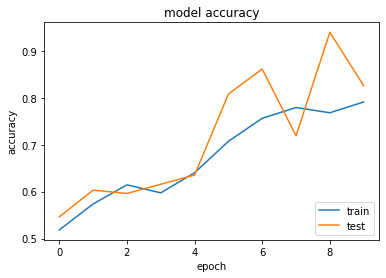

In [58]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

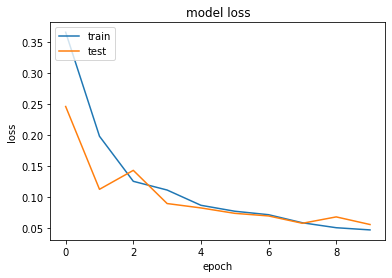

In [59]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [60]:
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve

In [61]:
y_val_pred_cat1 = (np.asarray(y_pred)).round()

In [62]:
y_val_pred_cat1

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [63]:
f1_score(y_test, y_val_pred_cat1, average='macro')

0.7409962545347584

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df.clean_text.tolist())
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
tfidf = pd.DataFrame(denselist, columns=feature_names)

In [31]:
tfidf

,aabex,aachen,aameo,aancor,aap,aar,aarnoud,ab,abalkhail,abandon,abat,abba,abbett,abbey,abbott,abboud,abbrevi,abc,abdel,abdelaziz,abdeljabbar,abdelrahim,abdelshakour,abdul,abdulaziz,abdulhadi,abdulkarim,abdulla,abdullah,abdulrahim,abe,abel,abercrombi,abex,abf,abi,abid,abil,abilen,abl,...,zambian,zayr,zdzislaw,zealand,zeebrugg,zellerbach,zenex,zenith,zentralbank,zentralsparkass,zero,zeropoint,zfour,zhai,zhao,zhejiang,zheng,zhou,zico,zier,zim,zimbabw,zimmer,zimoil,zinc,zinn,ziyang,zn,zoet,zolling,zondervan,zone,zoran,zseven,zuccherifici,zuckerman,zuheir,zulia,zurich,zurichbas
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
y = df[["topics_clean"]]

In [87]:
x = tfidf

In [88]:
x.shape

(7018, 15751)

In [89]:
y.shape

(7018, 1)

In [73]:
"""x = np.array(x).reshape(1,-1)
y = np.array(y).reshape(1,-1)"""

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf, df.topics_clean, test_size=0.3,
                                                    random_state=np.random)
print(X_train.shape, X_test.shape, len(y_train), len(y_test))

(4912, 15751) (2106, 15751) 4912 2106


In [92]:
tfidf.shape

(7018, 15751)

In [93]:
y.shape

(7018, 1)

In [98]:
from keras.preprocessing.text import Tokenizer
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)
maxlen=400
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)
V_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
V_test = pad_sequences(list_tokenized_test, maxlen=maxlen)
print(V_train.shape,V_test.shape)

(15751, 400) (15751, 400)


In [99]:
def getModel():
    inp = Input(shape=(maxlen, ))
    embed_size = 128
    x = Embedding(max_features, embed_size)(inp)
    x = LSTM(30, return_sequences=True,name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(5, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [100]:
model = getModel()
batch_size = 32
epochs = 10
file_path="../weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)


callbacks_list = [checkpoint, early] #early
history = model.fit(V_train,y_train,  batch_size=batch_size, epochs=epochs, validation_split=0.1,callbacks=callbacks_list)

ValueError: ignored